# AI model for training (shark fin) artifacts on GOES-R

[How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images](https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)

[TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
nr.seed = 42

In [3]:
data_dir = '/home/radomako/myDataset/'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['fillin', 'sharkfin']


In [4]:
for data in trainloader.dataset:
    print(data[0].shape, data[1])
    break

torch.Size([3, 224, 224]) 0


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
epochs = 1
steps = 0
running_loss = 0
print_every = 1#10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        print(steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print('REACHED RUNNING LOSS')
        if steps % print_every == 0:
            print('I am working')
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'aerialmodel.pth')

1
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 2.107.. Test loss: 0.786.. Test accuracy: 0.938
2
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 1.875.. Test loss: 0.721.. Test accuracy: 0.938
3
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 1.268.. Test loss: 0.436.. Test accuracy: 0.938
4
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 1.170.. Test loss: 0.446.. Test accuracy: 0.941
5
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.497.. Test loss: 0.316.. Test accuracy: 0.891
6
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.281.. Test loss: 0.221.. Test accuracy: 0.938
7
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.273.. Test loss: 0.318.. Test accuracy: 0.891
8
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.250.. Test loss: 0.160.. Test accuracy: 0.938
9
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.267.. Test loss: 0.500.. Test accuracy: 0.969
10
REACHED RUNNING LOSS
I am

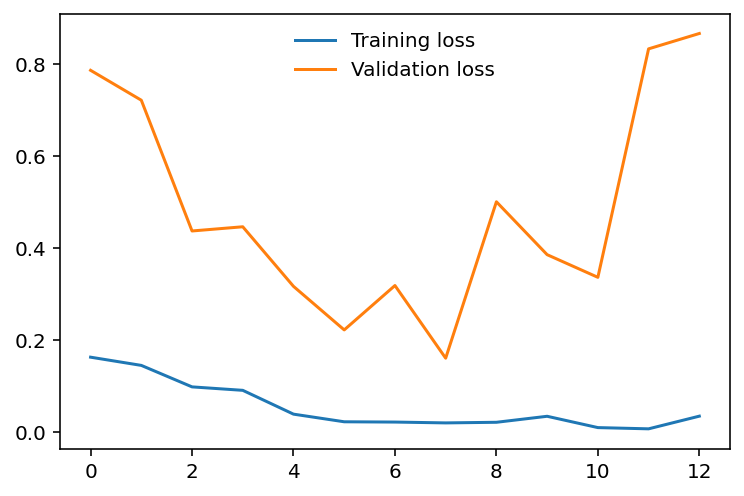

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

#### Took 1 hour to train. Dataset has 100 sharkfins and 889 fillins. Together that is 989 samples. The train to test split is 80% to 20%. Average test accuracy is over 90%!